In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score

# admissions table

In [2]:
# read admission data

df = '/mimic-iv-2.2'
def read_admissions_table(df):
    adm = pd.read_csv('hosp/admissions.csv.gz')
    adm = adm[['subject_id','hadm_id', 'race']]

    return adm

adm = read_admissions_table(df)
adm.head()


,subject_id,hadm_id,race
0,10000032,22595853,WHITE
1,10000032,22841357,WHITE
2,10000032,25742920,WHITE
3,10000032,29079034,WHITE
4,10000068,25022803,WHITE


In [3]:
# count race values

adm['race'].value_counts()

WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

In [4]:
# inplace race values

adm['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
adm['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
adm['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
adm['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
adm['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
#take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
adm['race'].loc[~adm['race'].isin(adm['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'  
adm['race'].value_counts()

C:\Users\wjw_4\AppData\Local\Temp\ipykernel_3056\1520705636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm['race'].loc[~adm['race'].isin(adm['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'


WHITE                     288154
BLACK/AFRICAN AMERICAN     69958
OTHER/UNKNOWN              33014
HISPANIC/LATINO            25212
ASIAN                      14893
Name: race, dtype: int64

In [6]:
# delete all rows contains null value

adm.dropna(inplace=True)
adm.info()
adm['race'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   subject_id  431231 non-null  int64 
 1   hadm_id     431231 non-null  int64 
 2   race        431231 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.9+ MB


WHITE                     288154
BLACK/AFRICAN AMERICAN     69958
OTHER/UNKNOWN              33014
HISPANIC/LATINO            25212
ASIAN                      14893
Name: race, dtype: int64

# patients table

In [7]:

# read patients table

def read_patients_table(df):
    pats = pd.read_csv('hosp/patients.csv.gz')
    pats = pats[['subject_id', 'gender', 'anchor_age']]

    return pats

patients = read_patients_table(df)
patients.head()

,subject_id,gender,anchor_age
0,10000032,F,52
1,10000048,F,23
2,10000068,F,19
3,10000084,M,72
4,10000102,F,27


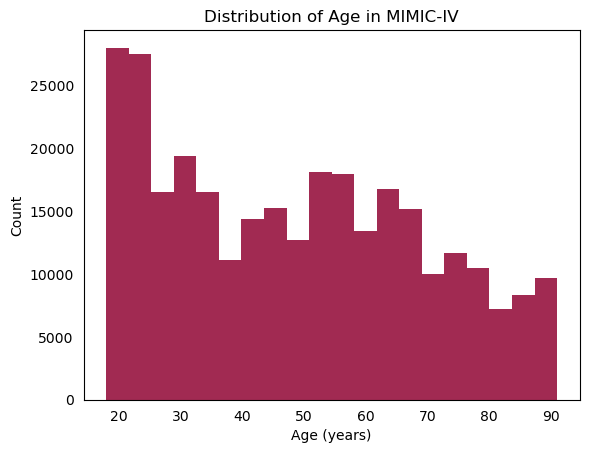

In [6]:
# the distribution of age
plt.hist(patients['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

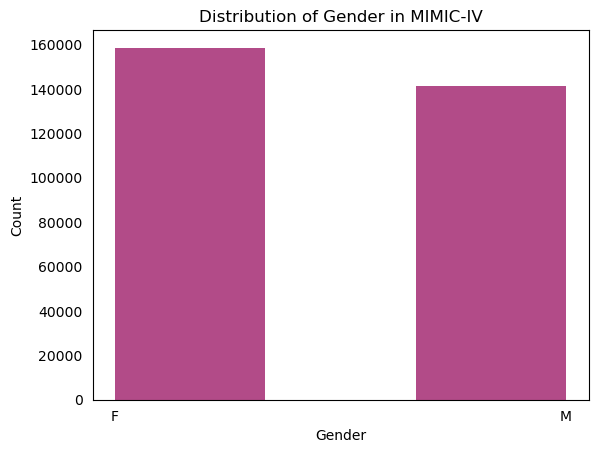

In [7]:
# distribution of gender
plt.hist(patients['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

In [8]:
# merge the PATIENTS table with ADMISSIONS table

admits_patients = pd.merge(adm, patients, how='inner', on='subject_id')
admits_patients = admits_patients[['subject_id','race','gender','anchor_age']]
admits_patients.head()

,subject_id,race,gender,anchor_age
0,10000032,WHITE,F,52
1,10000032,WHITE,F,52
2,10000032,WHITE,F,52
3,10000032,WHITE,F,52
4,10000068,WHITE,F,19


In [9]:
# delete all rows contains null value

admits_patients.dropna(inplace=True)
admits_patients.info()
admits_patients['race'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431231 entries, 0 to 431230
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   subject_id  431231 non-null  int64 
 1   race        431231 non-null  object
 2   gender      431231 non-null  object
 3   anchor_age  431231 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.5+ MB


WHITE                     288154
BLACK/AFRICAN AMERICAN     69958
OTHER/UNKNOWN              33014
HISPANIC/LATINO            25212
ASIAN                      14893
Name: race, dtype: int64

## diagnoses_icd table

In [10]:
# read the diagnoses table and find out the data structure

def read_diagnoses_table(df):
    diag = pd.read_csv('hosp/diagnoses_icd.csv.gz')
    diag = diag[['subject_id','hadm_id', 'icd_code','icd_version']]

    return diag

diag = read_diagnoses_table(df)
diag.head()

,subject_id,hadm_id,icd_code,icd_version
0,10000032,22595853,5723,9
1,10000032,22595853,78959,9
2,10000032,22595853,5715,9
3,10000032,22595853,07070,9
4,10000032,22595853,496,9


In [11]:
diag.icd_version.value_counts()

9     2766877
10    1989449
Name: icd_version, dtype: int64

In [12]:
print('There are {} unique ICD9 codes in this dataset.'.format(diag['icd_code'].value_counts().count()))

There are 25809 unique ICD9 codes in this dataset.


In [13]:
# Filter out codes from ICD9 codes
diag['recode'] = diag['icd_code']
diag['recode'] = diag['recode'][~diag['recode'].str.contains("[a-zA-Z]").fillna(False)]
diag['recode'].fillna(value='999', inplace=True)

diag['recode'] = diag['recode'].str.slice(start=0, stop=3, step=1)
diag['recode'] = diag['recode'].astype(int)
diag.head()

,subject_id,hadm_id,icd_code,icd_version,recode
0,10000032,22595853,5723,9,572
1,10000032,22595853,78959,9,789
2,10000032,22595853,5715,9,571
3,10000032,22595853,07070,9,70
4,10000032,22595853,496,9,496


In [14]:
# read the icd table

def read_icd_table(df):
    icd = pd.read_csv('hosp/d_icd_procedures.csv.gz')
    icd = icd[['icd_code','long_title']]

    return icd

icd = read_icd_table(df)

In [15]:
# merge the diag table with icd table

diag_icd = pd.merge(diag, icd, how='inner', on='icd_code')
diag_icd = diag_icd[['subject_id','hadm_id','recode']]
diag_icd.head()

,subject_id,hadm_id,recode
0,10000032,22595853,496
1,10000032,22841357,496
2,10000032,25742920,496
3,10000032,29079034,496
4,10000980,29654838,496


In [16]:
# delete all rows contains null value

diag_icd.dropna(inplace=True)
diag_icd.info()
diag_icd['recode'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537989 entries, 0 to 537988
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   subject_id  537989 non-null  int64
 1   hadm_id     537989 non-null  int64
 2   recode      537989 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 14.4 MB


401    100868
272     64665
311     34632
584     30825
276     24288
        ...  
819         1
465         1
114         1
770         1
976         1
Name: recode, Length: 415, dtype: int64

In [17]:
# merge the diag_icd with admission_patient

diag_icd_adm_pats = pd.merge(diag_icd, admits_patients, how='inner', on='subject_id')
diag_icd_adm_pats.head()

,subject_id,hadm_id,recode,race,gender,anchor_age
0,10000032,22595853,496,WHITE,F,52
1,10000032,22595853,496,WHITE,F,52
2,10000032,22595853,496,WHITE,F,52
3,10000032,22595853,496,WHITE,F,52
4,10000032,22841357,496,WHITE,F,52


In [18]:
# delete all rows contains null value

diag_icd_adm_pats.dropna(inplace=True)
diag_icd_adm_pats.info()
diag_icd_adm_pats['race'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383880 entries, 0 to 4383879
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject_id  int64 
 1   hadm_id     int64 
 2   recode      int32 
 3   race        object
 4   gender      object
 5   anchor_age  int64 
dtypes: int32(1), int64(3), object(2)
memory usage: 217.4+ MB


WHITE                     2850886
BLACK/AFRICAN AMERICAN     997590
HISPANIC/LATINO            290677
OTHER/UNKNOWN              169460
ASIAN                       75267
Name: race, dtype: int64

# omr table

In [19]:
# read the omr table

def read_omr_table(df):
    omr = pd.read_csv('hosp/omr.csv.gz')
    omr = omr[['subject_id','chartdate','seq_num','result_name','result_value']]

    return omr

omr = read_omr_table(df)
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [20]:
omr.result_name.value_counts()

Blood Pressure                      2169549
Weight (Lbs)                        1889542
BMI (kg/m2)                         1662112
Height (Inches)                      706906
Blood Pressure Sitting                 3400
Blood Pressure Lying                   2764
Blood Pressure Standing (1 min)        2560
Blood Pressure Standing (3 mins)        626
BMI                                     554
Blood Pressure Standing                 523
Weight                                  354
eGFR                                    240
Height                                   39
Name: result_name, dtype: int64

In [21]:
omr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6439169 entries, 0 to 6439168
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   subject_id    int64 
 1   chartdate     object
 2   seq_num       int64 
 3   result_name   object
 4   result_value  object
dtypes: int64(2), object(3)
memory usage: 245.6+ MB


In [22]:
omr_list = omr.groupby('subject_id')['result_name'].apply(list).reset_index()
omr_list.head()

,subject_id,result_name
0,10000032,"[Blood Pressure, Weight (Lbs), BMI (kg/m2), He..."
1,10000084,"[BMI (kg/m2), Height (Inches), Weight (Lbs)]"
2,10000117,"[Blood Pressure, Weight (Lbs), Blood Pressure,..."
3,10000248,"[BMI (kg/m2), Height (Inches), Weight (Lbs)]"
4,10000280,"[Blood Pressure, Weight (Lbs), Blood Pressure,..."


In [23]:
# keep BP

omr_BP = omr[omr['result_name'] == 'Blood Pressure']

omr_BP[["systolic", "diastolic"]] = omr_BP["result_value"].str.split("/", expand=True)

omr_BP.drop("result_value", axis=1, inplace=True)
omr_BP = omr_BP[['subject_id','systolic','diastolic']]
omr_BP.head()

C:\Users\wjw_4\AppData\Local\Temp\ipykernel_3056\948502830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_BP[["systolic", "diastolic"]] = omr_BP["result_value"].str.split("/", expand=True)
C:\Users\wjw_4\AppData\Local\Temp\ipykernel_3056\948502830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_BP[["systolic", "diastolic"]] = omr_BP["result_value"].str.split("/", expand=True)
C:\Users\wjw_4\AppData\Local\Temp\ipykernel_3056\948502830.py:7: SettingWithCopyWarning: 
A value is trying to be se

,subject_id,systolic,diastolic
0,10000032,110,65
21,10000032,106,60
24,10000032,121,77
27,10000032,100,60
33,10000032,102,60


In [24]:
# delete all rows contains null value

omr_BP.dropna(inplace=True)
omr_BP.info()
omr_BP['systolic'].value_counts()
omr_BP['diastolic'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169549 entries, 0 to 6439168
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject_id  int64 
 1   systolic    object
 2   diastolic   object
dtypes: int64(1), object(2)
memory usage: 66.2+ MB


70      195589
80      188744
60      122250
78       91062
72       84456
         ...  
04           1
185          1
0101         1
171          1
170          1
Name: diastolic, Length: 198, dtype: int64

# filter diagnoses is Spesis

In [25]:
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code
for num, cat_range in enumerate(icd9_ranges):
    diag_icd['recode'] = np.where(diag_icd['recode'].between(cat_range[0],cat_range[1]), num, diag_icd['recode'])
    
diag_icd['super_category'] = diag_icd['recode'].replace(diag_dict)
diag_icd.head()

,subject_id,hadm_id,recode,super_category
0,10000032,22595853,7,respiratory
1,10000032,22841357,7,respiratory
2,10000032,25742920,7,respiratory
3,10000032,29079034,7,respiratory
4,10000980,29654838,7,respiratory


In [26]:
# Create list of diagnoses
hadm_list = diag_icd.groupby('hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()

,hadm_id,super_category
0,20000019,"[endocrine, circulatory, genitourinary, endocr..."
1,20000034,[injury]
2,20000041,"[circulatory, endocrine]"
3,20000057,[circulatory]
4,20000235,"[infectious, endocrine, digestive]"


In [27]:
# Convert diagnoses list into 0-1 matrix
hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

C:\Users\wjw_4\AppData\Local\Temp\ipykernel_3056\1495860956.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0


In [28]:
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [29]:
# Merge with main dataframe

final = pd.merge(diag_icd_adm_pats, hadm_item, how='inner', on='hadm_id')
final.head()

,subject_id,hadm_id,recode,race,gender,anchor_age,blood,circulatory,congenital,digestive,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10000032,22841357,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
# Draw the plot of distribution of diagnoses

plt.hist(diag['icd_code'], bins=20, color='#61bdd1')
plt.ylabel('Count')
plt.xlabel('icd_code')
plt.title('Distribution of hosp-diagnoses in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

KeyboardInterrupt: 

In [30]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383880 entries, 0 to 4383879
Data columns (total 23 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   subject_id     int64 
 1   hadm_id        int64 
 2   recode         int32 
 3   race           object
 4   gender         object
 5   anchor_age     int64 
 6   blood          uint8 
 7   circulatory    uint8 
 8   congenital     uint8 
 9   digestive      uint8 
 10  endocrine      uint8 
 11  genitourinary  uint8 
 12  infectious     uint8 
 13  injury         uint8 
 14  mental         uint8 
 15  misc           uint8 
 16  muscular       uint8 
 17  neoplasms      uint8 
 18  nervous        uint8 
 19  pregnancy      uint8 
 20  prenatal       uint8 
 21  respiratory    uint8 
 22  skin           uint8 
dtypes: int32(1), int64(3), object(2), uint8(17)
memory usage: 288.5+ MB


In [31]:
final.recode.value_counts()

401    752132
272    500145
311    357013
584    259258
276    203499
        ...  
522         1
993         1
629         1
876         1
887         1
Name: recode, Length: 415, dtype: int64

In [32]:
# delete all rows contains null value

final.dropna(inplace=True)
final.info()
final['recode'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383880 entries, 0 to 4383879
Data columns (total 23 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   subject_id     int64 
 1   hadm_id        int64 
 2   recode         int32 
 3   race           object
 4   gender         object
 5   anchor_age     int64 
 6   blood          uint8 
 7   circulatory    uint8 
 8   congenital     uint8 
 9   digestive      uint8 
 10  endocrine      uint8 
 11  genitourinary  uint8 
 12  infectious     uint8 
 13  injury         uint8 
 14  mental         uint8 
 15  misc           uint8 
 16  muscular       uint8 
 17  neoplasms      uint8 
 18  nervous        uint8 
 19  pregnancy      uint8 
 20  prenatal       uint8 
 21  respiratory    uint8 
 22  skin           uint8 
dtypes: int32(1), int64(3), object(2), uint8(17)
memory usage: 288.5+ MB


401    752132
272    500145
311    357013
584    259258
276    203499
        ...  
522         1
993         1
629         1
876         1
887         1
Name: recode, Length: 415, dtype: int64

In [41]:
# filter the diagnoses of Spesis

fs = final[final['recode'] == 995]

fs.head()

,subject_id,hadm_id,recode,race,gender,anchor_age,blood,circulatory,congenital,digestive,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
11007,10137553,24893925,995,BLACK/AFRICAN AMERICAN,F,80,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
11008,10137553,24893925,995,BLACK/AFRICAN AMERICAN,F,80,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
11009,10137553,24893925,995,BLACK/AFRICAN AMERICAN,F,80,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
11010,10137553,24893925,995,BLACK/AFRICAN AMERICAN,F,80,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
11011,10137553,24893925,995,BLACK/AFRICAN AMERICAN,F,80,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0


In [42]:
# patients who are diagnosed as Spesis, all the values

omr_BP_fs = pd.merge(fs,omr_BP, how='inner', on='subject_id')

omr_BP_fs.head()

,subject_id,hadm_id,recode,race,gender,anchor_age,blood,circulatory,congenital,digestive,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,systolic,diastolic
0,10274866,23488422,995,HISPANIC/LATINO,M,65,0,1,0,0,...,0,0,0,0,0,0,0,0,104,72
1,10274866,23488422,995,HISPANIC/LATINO,M,65,0,1,0,0,...,0,0,0,0,0,0,0,0,110,66
2,10274866,23488422,995,HISPANIC/LATINO,M,65,0,1,0,0,...,0,0,0,0,0,0,0,0,110,80
3,10274866,23488422,995,HISPANIC/LATINO,M,65,0,1,0,0,...,0,0,0,0,0,0,0,0,90,70
4,10274866,23488422,995,HISPANIC/LATINO,M,65,0,1,0,0,...,0,0,0,0,0,0,0,0,120,82


In [35]:
# filter other diagnoses- randomly choose 3 other icd_codes

fo = final['recode'].isin([311, 584, 276])

ffo = final[fo]
ffo.info()
ffo.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819770 entries, 8 to 4374831
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subject_id     819770 non-null  int64 
 1   hadm_id        819770 non-null  int64 
 2   recode         819770 non-null  int32 
 3   race           819770 non-null  object
 4   gender         819770 non-null  object
 5   anchor_age     819770 non-null  int64 
 6   blood          819770 non-null  uint8 
 7   circulatory    819770 non-null  uint8 
 8   congenital     819770 non-null  uint8 
 9   digestive      819770 non-null  uint8 
 10  endocrine      819770 non-null  uint8 
 11  genitourinary  819770 non-null  uint8 
 12  infectious     819770 non-null  uint8 
 13  injury         819770 non-null  uint8 
 14  mental         819770 non-null  uint8 
 15  misc           819770 non-null  uint8 
 16  muscular       819770 non-null  uint8 
 17  neoplasms      819770 non-null  uint8 
 18  ner

,subject_id,hadm_id,recode,race,gender,anchor_age,blood,circulatory,congenital,digestive,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
8,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16,10000032,25742920,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
# delete all rows contains null value

omr_BP_fs.dropna(inplace=True)
omr_BP_fs.info()
omr_BP_fs['recode'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166309 entries, 0 to 166308
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subject_id     166309 non-null  int64 
 1   hadm_id        166309 non-null  int64 
 2   recode         166309 non-null  int32 
 3   race           166309 non-null  object
 4   gender         166309 non-null  object
 5   anchor_age     166309 non-null  int64 
 6   blood          166309 non-null  uint8 
 7   circulatory    166309 non-null  uint8 
 8   congenital     166309 non-null  uint8 
 9   digestive      166309 non-null  uint8 
 10  endocrine      166309 non-null  uint8 
 11  genitourinary  166309 non-null  uint8 
 12  infectious     166309 non-null  uint8 
 13  injury         166309 non-null  uint8 
 14  mental         166309 non-null  uint8 
 15  misc           166309 non-null  uint8 
 16  muscular       166309 non-null  uint8 
 17  neoplasms      166309 non-null  uint8 
 18  nerv

995    166309
Name: recode, dtype: int64

In [44]:
# save this version of the dataframe to a csv. 

omr_BP_fs.to_csv('fsnotime.csv.gz')

In [37]:
# patients diagnoses data and omr

omr_BP_final = pd.merge(final,omr_BP, how='inner', on='subject_id')

omr_BP_final.head()

,subject_id,hadm_id,recode,race,gender,anchor_age,blood,circulatory,congenital,digestive,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,systolic,diastolic
0,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,110,65
1,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,106,60
2,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,121,77
3,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,100,60
4,10000032,22595853,496,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,102,60


In [38]:
# patients diagnoses(random 3) and omr

omr_BP_ffo = pd.merge(ffo,omr_BP, how='inner', on='subject_id')

omr_BP_ffo.head()


,subject_id,hadm_id,recode,race,gender,anchor_age,blood,circulatory,congenital,digestive,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,systolic,diastolic
0,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,110,65
1,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,106,60
2,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,121,77
3,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,100,60
4,10000032,22841357,276,WHITE,F,52,0,0,0,0,...,0,0,0,0,0,0,1,0,102,60


In [39]:
omr_BP_ffo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41155089 entries, 0 to 41155088
Data columns (total 25 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   subject_id     int64 
 1   hadm_id        int64 
 2   recode         int32 
 3   race           object
 4   gender         object
 5   anchor_age     int64 
 6   blood          uint8 
 7   circulatory    uint8 
 8   congenital     uint8 
 9   digestive      uint8 
 10  endocrine      uint8 
 11  genitourinary  uint8 
 12  infectious     uint8 
 13  injury         uint8 
 14  mental         uint8 
 15  misc           uint8 
 16  muscular       uint8 
 17  neoplasms      uint8 
 18  nervous        uint8 
 19  pregnancy      uint8 
 20  prenatal       uint8 
 21  respiratory    uint8 
 22  skin           uint8 
 23  systolic       object
 24  diastolic      object
dtypes: int32(1), int64(3), object(4), uint8(17)
memory usage: 3.3+ GB


In [45]:
# save this version of the dataframe to a csv. 

omr_BP_ffo.to_csv('ffonotime.csv.gz')

# prescriptions time

In [79]:
# read the prescription table

def read_pre_table(df):
    pre = pd.read_csv('hosp/prescriptions.csv.gz')
    pre = pre[['subject_id','starttime','stoptime','drug']]
    return pre

pre = read_pre_table(df)
pre.head()

C:\Users\wjw_4\AppData\Local\Temp\ipykernel_12352\4120338358.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  pre = pd.read_csv('hosp/prescriptions.csv.gz')


,subject_id,starttime,stoptime,drug
0,10000032,2180-05-07 01:00:00,2180-05-07 22:00:00,Acetaminophen
1,10000032,2180-05-07 00:00:00,2180-05-07 22:00:00,Sodium Chloride 0.9% Flush
2,10000032,2180-05-08 08:00:00,2180-05-07 22:00:00,Furosemide
3,10000032,2180-05-07 01:00:00,2180-05-07 22:00:00,Raltegravir
4,10000032,2180-05-07 00:00:00,2180-05-07 22:00:00,Heparin


In [81]:
# add starttime to the fs dataframe

fs_time = pd.merge(omr_BP_fs,pre, how='inner', on='subject_id')
fs_time.head()

MemoryError: Unable to allocate 1.06 GiB for an array with shape (142215286,) and data type int64

In [26]:
fs_time.recode.value_counts()

995    142215286
Name: recode, dtype: int64

In [35]:
fs_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142215286 entries, 0 to 142215285
Data columns (total 12 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subject_id  int64 
 1   hadm_id     int64 
 2   recode      int32 
 3   long_title  object
 4   race        object
 5   gender      object
 6   anchor_age  int64 
 7   systolic    object
 8   diastolic   object
 9   starttime   object
 10  stoptime    object
 11  drug        object
dtypes: int32(1), int64(3), object(8)
memory usage: 13.2+ GB


In [36]:
# save this version of the dataframe to a csv. It will be used as baseline

fs_time.to_csv('baseline.csv.gz')

In [83]:
time = pre[['subject_id','starttime']]
time.head()

,subject_id,starttime
0,10000032,2180-05-07 01:00:00
1,10000032,2180-05-07 00:00:00
2,10000032,2180-05-08 08:00:00
3,10000032,2180-05-07 01:00:00
4,10000032,2180-05-07 00:00:00


# out of memoryerror, delete all null value rows
omr_BP_final.dropna(subset=['hadm_id'], inplace=True)
omr_BP_final.dropna(subset=['icd_code'], inplace=True)
omr_BP_final.dropna(subset=['long_title'], inplace=True)
omr_BP_final.dropna(subset=['recode'], inplace=True)
omr_BP_final.dropna(subset=['race'], inplace=True)
omr_BP_final.dropna(subset=['gender'], inplace=True)
omr_BP_final.dropna(subset=['anchor_age'], inplace=True)
omr_BP_final.dropna(subset=['blood'], inplace=True)
omr_BP_final.dropna(subset=['circulatory'], inplace=True)
omr_BP_final.dropna(subset=['congenital'], inplace=True)
omr_BP_final.dropna(subset=['digestive'], inplace=True)
omr_BP_final.dropna(subset=['endocrine'], inplace=True)
omr_BP_final.dropna(subset=['genitourinary'], inplace=True)
omr_BP_final.dropna(subset=['infectious'], inplace=True)
omr_BP_final.dropna(subset=['injury'], inplace=True)
omr_BP_final.dropna(subset=['mental'], inplace=True)
omr_BP_final.dropna(subset=['misc'], inplace=True)
omr_BP_final.dropna(subset=['muscular'], inplace=True)
omr_BP_final.dropna(subset=['neoplasms'], inplace=True)
omr_BP_final.dropna(subset=['nervous'], inplace=True)
omr_BP_final.dropna(subset=['pregnancy'], inplace=True)
omr_BP_final.dropna(subset=['prenantal'], inplace=True)
omr_BP_final.dropna(subset=['respiratory'], inplace=True)
omr_BP_final.dropna(subset=['skin'], inplace=True)
omr_BP_final.dropna(subset=['systolic'], inplace=True)
omr_BP_final.dropna(subset=['diastolic'], inplace=True)

# add starttime to the final dataframe

final_time = pd.merge(omr_BP_final,time, how='inner', on='subject_id')
final_time.head()

In [84]:
# add starttime to the ffo

ffo_time = pd.merge(omr_BP_ffo,time, how='inner', on='subject_id')
ffo_time.head()
ffo_time.info()

MemoryError: Unable to allocate 314. MiB for an array with shape (41155089,) and data type int64